Nome: Luiz Henrique Lourenção



Nusp: 10284862

#Identificação do Problema
A base de dados consiste em mais de 20000 avaliações de hoteis retiradas do Trip Advisor. A base de dados se encontra aqui https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews. A base de dados possui duas colunas, um texto, que é o comentário que a pessoa fez sobre determinado hotel, e uma coluna de "rating" que é a "nota" de 1 a 5 para este hotel. Portanto, o texto deveria condizer com a nota dada. Ex: hotel é ótimo, nota 5. / hotel é péssimo, nota 1.

O meu objetivo é minerar os dados desses comentários para tentar prever, de acordo com um novo comentário, a nota que essa pessoa daria para este hotel.

# Installing and importing the packages

In [53]:
!pip install ktrain
!pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 3.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=910f053fe581cb73cb39eb05f7af5faed7bc31b9cffc5c20d6db20816391a881
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers


In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import ktrain
from ktrain import text
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import networkx as nx
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer
import logging
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# Preparing the database

In [75]:
df_reviews = pd.read_csv('tripadvisor_hotel_reviews.csv');
df_reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [66]:
# Separando o target da feature
features = ["Review"]
target = ["Rating"]
X = df_reviews[features]
y = df_reviews[target]

# Separando em conjunto de treino e de testes -> 80% treino 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)
X_train.head()

,Review
3717,"great holiday riu bambu, wife thoroughly enjoy..."
6225,"n't worry love, family stayed marriott resort ..."
18433,great heard corte grimani trip advisor read go...
11145,loved hotel fusion just gotten stay fusion lov...
32,"noise airconditioner-a standard, arranged stay..."


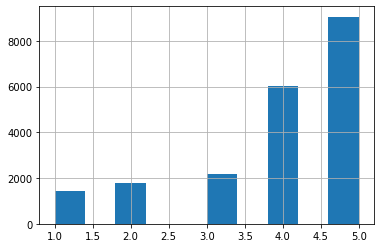

In [67]:
df_reviews.Rating.hist()

# Bag of Words

## Pre-processing the data

In [27]:
# remoção de pontuacao e stopwords

def remove_stopwords(text,lang,domain_stopwords=[]):
  
  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'
  
  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()


In [28]:
# stemming
def stemming(text,lang):
  
  stemmer = PorterStemmer() # stemming para ingles
  
  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese
    
  tokens = word_tokenize(text) #obtem tokens
  
  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "
    
  return sentence_stem.strip()


In [30]:
# obtendo a bag-of-words de treino
def compute_bag_of_words_train(dataset,lang,domain_stopwords=[]):
  
  d = []
  for index,row in dataset.iterrows():
    text = row['Review'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  matrix = CountVectorizer(max_features=100)
  X = matrix.fit_transform(d)
  
  count_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return count_vect_df, matrix

# obtendo a bag-of-words de teste
def compute_bag_of_words_test(dataset,lang,matrix,domain_stopwords=[]):
  
  d = []
  for index,row in dataset.iterrows():
    text = row['Review'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  X = matrix.transform(d)
  
  count_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return count_vect_df


bow_train, matrix = compute_bag_of_words_train(X_train,'english')
bow_test = compute_bag_of_words_test(X_test, 'english', matrix)

In [41]:
# obtendo a VSM com TFIDF de treino
def compute_vsm_tfidf_train(dataset,lang,domain_stopwords=[]):
  d = []
  for index,row in dataset.iterrows():
    text = row['Review'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  matrix = TfidfVectorizer(max_features=100)
  X = matrix.fit_transform(d)
  
  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df, matrix

# obtendo a VSM com TFIDF de teste
def compute_vsm_tfidf_test(dataset,lang,matrix,domain_stopwords=[]):
  d = []
  for index,row in dataset.iterrows():
    text = row['Review'] #texto do evento
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  X = matrix.transform(d)
  
  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df

vsm_train, matrix = compute_vsm_tfidf_train(X_train,'english')
vsm_test = compute_vsm_tfidf_test(X_test, 'english', matrix)

## Classification

### Decision Tree

In [31]:
model_tree_bow = DecisionTreeClassifier(random_state=5)

model_tree_bow.fit(bow_train, y_train)

bow_tree_pred = model_tree_bow.predict(bow_test)

print(classification_report(y_test, bow_tree_pred))

              precision    recall  f1-score   support

           1       0.30      0.32      0.31       284
           2       0.15      0.15      0.15       359
           3       0.15      0.15      0.15       437
           4       0.35      0.36      0.35      1208
           5       0.55      0.55      0.55      1811

    accuracy                           0.40      4099
   macro avg       0.30      0.30      0.30      4099
weighted avg       0.40      0.40      0.40      4099



In [42]:
model_tree_vsm = DecisionTreeClassifier(random_state=5)

model_tree_vsm.fit(vsm_train, y_train)

vsm_tree_pred = model_tree_vsm.predict(vsm_test)

print(classification_report(y_test, vsm_tree_pred))

              precision    recall  f1-score   support

           1       0.31      0.30      0.30       284
           2       0.18      0.17      0.17       359
           3       0.16      0.16      0.16       437
           4       0.36      0.36      0.36      1208
           5       0.56      0.57      0.57      1811

    accuracy                           0.41      4099
   macro avg       0.31      0.31      0.31      4099
weighted avg       0.41      0.41      0.41      4099



### Multi-layer Perceptron and SVM

In [45]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    print(classification_report(y_test, Y_pred))

In [49]:
experimentos = {
    "MLP com 4 neurônios e 1camadas escondidas" : MLPClassifier(hidden_layer_sizes=(4,)),
    "MLP com 7 neurônios e 2 camadas escondidas " : MLPClassifier(hidden_layer_sizes=(3,4)),
    "MLP com 12 neurônios e 3 camadas escondidas" : MLPClassifier(hidden_layer_sizes=(5,3,2)), 
    "MLP com 35 neurônios e 1 camadas escondidas" : MLPClassifier(hidden_layer_sizes=(35,)),   
    "SVM com kernel sigmoid" : SVC(kernel = 'sigmoid'),
    "SVM com kernel poly e grau 3" : SVC(kernel = 'poly'),
    "SVM com kernel poly e grau 5" : SVC(kernel = 'poly', degree = 5),
    "SVM com kernel rbf" : SVC()
}

In [51]:
for key in experimentos.keys():
  print('Modelo ' + key + '\n')
  model = experimentos[key]
  evaluate_model(model, bow_train, y_train['Rating'].to_list(), bow_test, y_test['Rating'].to_list())

Modelo MLP com 4 neurônios e 1camadas escondidas

              precision    recall  f1-score   support

           1       0.48      0.63      0.55       284
           2       0.32      0.25      0.28       359
           3       0.27      0.05      0.08       437
           4       0.45      0.41      0.43      1208
           5       0.62      0.78      0.69      1811

    accuracy                           0.54      4099
   macro avg       0.43      0.42      0.41      4099
weighted avg       0.50      0.54      0.50      4099

Modelo MLP com 7 neurônios e 2 camadas escondidas 

              precision    recall  f1-score   support

           1       0.45      0.64      0.53       284
           2       0.30      0.17      0.22       359
           3       0.28      0.08      0.12       437
           4       0.45      0.46      0.45      1208
           5       0.63      0.75      0.69      1811

    accuracy                           0.53      4099
   macro avg       0.42      

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.40      0.64      0.50       284
           2       0.26      0.13      0.17       359
           3       0.00      0.00      0.00       437
           4       0.36      0.33      0.35      1208
           5       0.61      0.80      0.69      1811

    accuracy                           0.51      4099
   macro avg       0.33      0.38      0.34      4099
weighted avg       0.43      0.51      0.46      4099

Modelo MLP com 35 neurônios e 1 camadas escondidas



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           1       0.52      0.53      0.52       284
           2       0.31      0.25      0.28       359
           3       0.24      0.16      0.19       437
           4       0.41      0.40      0.40      1208
           5       0.61      0.69      0.65      1811

    accuracy                           0.50      4099
   macro avg       0.42      0.41      0.41      4099
weighted avg       0.48      0.50      0.49      4099

Modelo SVM com kernel sigmoid

              precision    recall  f1-score   support

           1       0.12      0.31      0.17       284
           2       0.12      0.04      0.06       359
           3       0.25      0.03      0.05       437
           4       0.38      0.24      0.29      1208
           5       0.48      0.65      0.55      1811

    accuracy                           0.38      4099
   macro avg       0.27      0.25      0.23      4099
weighted avg       0.37      0.38      0.35   

In [40]:
model_mlp_bow = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=5)

model_mlp_bow.fit(bow_train, y_train['Rating'].to_list())

bow_mlp_pred = model_mlp_bow.predict(bow_test)

print(classification_report(y_test['Rating'].to_list(), bow_mlp_pred))

              precision    recall  f1-score   support

           1       0.50      0.56      0.53       284
           2       0.30      0.25      0.28       359
           3       0.28      0.10      0.15       437
           4       0.45      0.44      0.44      1208
           5       0.63      0.75      0.68      1811

    accuracy                           0.53      4099
   macro avg       0.43      0.42      0.42      4099
weighted avg       0.50      0.53      0.51      4099



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [52]:
model_mlp_vsm = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=5)

model_mlp_vsm.fit(vsm_train, y_train['Rating'].to_list())

vsm_mlp_pred = model_mlp_vsm.predict(vsm_test)

print(classification_report(y_test['Rating'].to_list(), vsm_mlp_pred))

              precision    recall  f1-score   support

           1       0.50      0.57      0.53       284
           2       0.35      0.26      0.30       359
           3       0.25      0.10      0.14       437
           4       0.44      0.42      0.43      1208
           5       0.62      0.74      0.67      1811

    accuracy                           0.53      4099
   macro avg       0.43      0.42      0.42      4099
weighted avg       0.49      0.53      0.50      4099



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# BERT (Fine-tuning)

In [68]:
df2 = df_reviews.astype({'Rating': str})

In [69]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(df2, 
                                                                   'Review',
                                                                   label_columns='Rating',
                                                                   maxlen=64, 
                                                                   max_features=10000,
                                                                   preprocess_mode='bert',
                                                                   lang=None,
                                                                   val_pct = 0.3,
                                                                   random_state=42
                                                                   )

['1', '2', '3', '4', '5']
         1    2    3    4    5
11642  0.0  0.0  0.0  0.0  1.0
14647  0.0  0.0  0.0  1.0  0.0
19292  0.0  1.0  0.0  0.0  0.0
18247  0.0  0.0  0.0  0.0  1.0
13199  0.0  0.0  0.0  0.0  1.0
['1', '2', '3', '4', '5']
         1    2    3    4    5
10726  1.0  0.0  0.0  0.0  0.0
14919  0.0  0.0  0.0  1.0  0.0
19098  0.0  0.0  1.0  0.0  0.0
2450   0.0  0.0  0.0  1.0  0.0
960    0.0  0.0  0.0  0.0  1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [70]:
model_bert = text.text_classifier('bert', (X_train, y_train) , preproc=preproc)
classifier = ktrain.get_learner(model_bert, train_data=(X_train, y_train), val_data=(X_test, y_test),batch_size=64)

Is Multi-Label? False
maxlen is 64
done.


In [71]:
classifier.fit_onecycle(lr=0.002, epochs=5)



begin training using onecycle policy with max lr of 0.002...
Epoch 1/5
225/225 [==============================] - 442s 2s/step - loss: 1.3961 - accuracy: 0.4287 - val_loss: 1.4859 - val_accuracy: 0.4328
Epoch 2/5
225/225 [==============================] - 411s 2s/step - loss: 1.3918 - accuracy: 0.4226 - val_loss: 1.5317 - val_accuracy: 0.3069
Epoch 3/5
225/225 [==============================] - 411s 2s/step - loss: 1.3912 - accuracy: 0.4246 - val_loss: 1.4131 - val_accuracy: 0.4328
Epoch 4/5
225/225 [==============================] - 411s 2s/step - loss: 1.3699 - accuracy: 0.4391 - val_loss: 1.3672 - val_accuracy: 0.4328
Epoch 5/5
225/225 [==============================] - 411s 2s/step - loss: 1.3630 - accuracy: 0.4436 - val_loss: 1.3605 - val_accuracy: 0.4328


In [72]:
classifier.validate()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       432
           1       0.00      0.00      0.00       523
           2       0.00      0.00      0.00       645
           3       0.00      0.00      0.00      1887
           4       0.43      1.00      0.60      2661

    accuracy                           0.43      6148
   macro avg       0.09      0.20      0.12      6148
weighted avg       0.19      0.43      0.26      6148



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,    0,    0,    0,  432],
       [   0,    0,    0,    0,  523],
       [   0,    0,    0,    0,  645],
       [   0,    0,    0,    0, 1887],
       [   0,    0,    0,    0, 2661]])

# BERT

In [56]:
# Load Sentence model (based on BERT) from URL
model_bert_emb = SentenceTransformer('distiluse-base-multilingual-cased')

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [57]:
dataset = pd.read_csv('tripadvisor_hotel_reviews.csv',encoding='iso8859')
dataset

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [76]:
dataset['bert_embedding'] = list(model_bert_emb.encode(dataset.Review.to_list()))

RuntimeError: ignored

#Uso do conhecimento
Algumas possíveis aplicações para este trabalho seriam: Indicar a provável nota para a avaliação de uma pessoa que fez apenas o comentário e esqueceu de dar a nota (essa aplicação ajudaria a realizar a média dos hotéis). Indicar a provável nota para a avaliação de uma pessoa em uma plataforma que coleta apenas comentários. Entre outras.

Peço desculpas pelo video de 7 minutos, eu não cronometrei o tempo e acabou passando MUITO. Sinto muito.

Link para o video: https://www.youtube.com/watch?v=YQu-RUt3IMk